# Udacity Self-Driving Car Engineer Nanodegree Program
## Project: Vehicle Detection and Tracking

---

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

---

### Load training data

In [1]:
import glob

car_images = glob.glob('data/vehicles/**/*.png')
noncar_images = glob.glob('data/non-vehicles/**/*.png')

print(len(car_images), 'vehicles loaded.')
print(len(noncar_images), 'non-vehicles loaded.')

8792 vehicles loaded.
8968 non-vehicles loaded.


### Visualize some of the training data

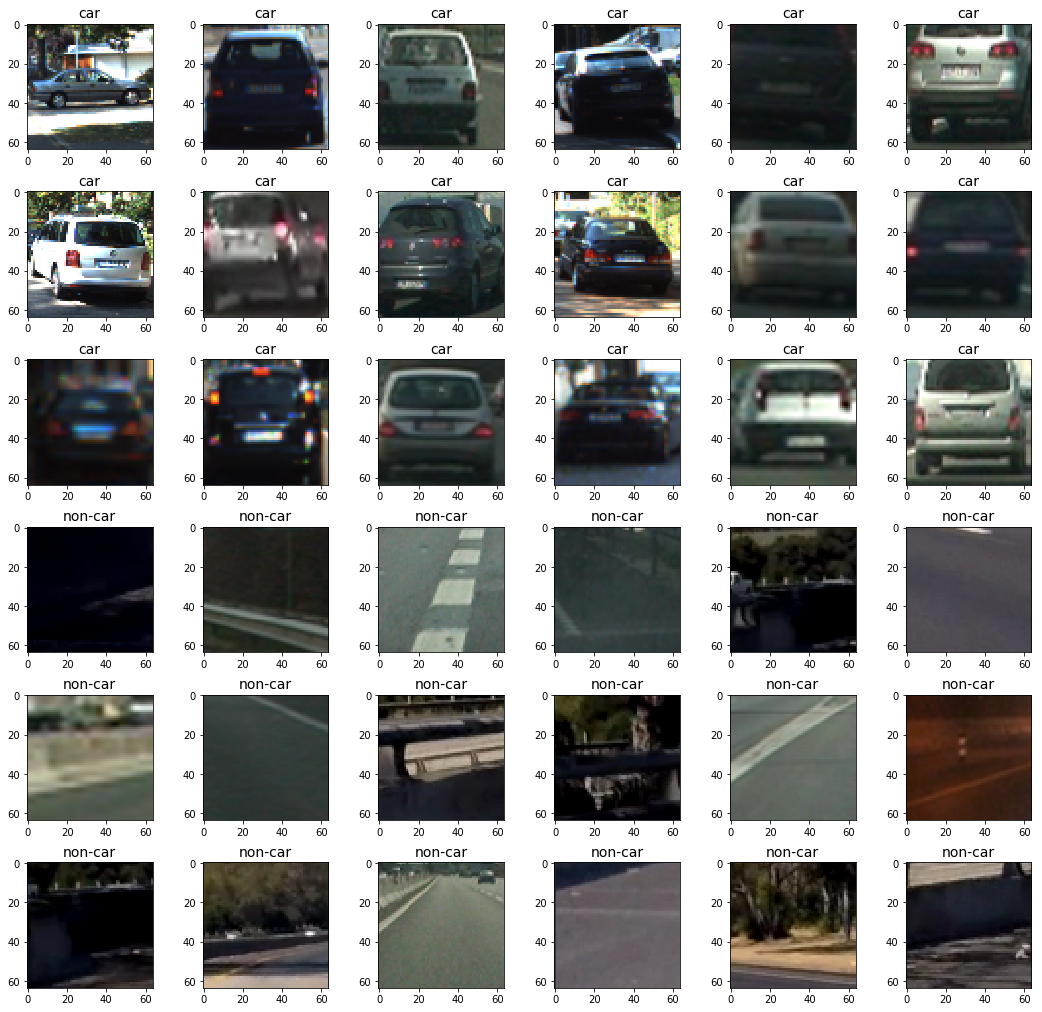

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

%matplotlib inline

fig, axes = plt.subplots(6, 6, figsize=(18,18))
fig.subplots_adjust(hspace=.2, wspace=.4)
axes = axes.ravel()

i=0
# Pick some car images randomly and plot them
for filepath in np.random.choice(car_images, 18):
    img = mpimg.imread(filepath)
    axes[i].set_title('car', fontsize=14)
    axes[i].imshow(img)
    i += 1
# Pick some non-car images randomly and plot them
for filepath in np.random.choice(noncar_images, 18):
    img = mpimg.imread(filepath)
    axes[i].set_title('non-car', fontsize=14)
    axes[i].imshow(img)
    i += 1

### Define a function to return HOG features and visualization

_The code for this method was mostly copied from the Udacity lesson materials:_

In [3]:
from skimage.feature import hog

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img,
                                  orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis,
                                  feature_vector=feature_vec,
                                  block_norm='L2-Hys')
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img,
                       orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis,
                       feature_vector=feature_vec,
                       block_norm='L2-Hys')
        return features

Here is a helper method to plot two images side-by-side:

In [4]:
def plot_images_side_by_side(left_img, left_title, right_img, right_title):
    """
    Display the images `leftImg` and `rightImg` side by side with image titles.
    :param left_img: Image to be plotted on the left side.
    :param left_title: Title to be plotted on the left side.
    :param right_img: Image to be plotted on the right side.
    :param right_title: Title to be plotted on the right side.
    """
    fig, axes = plt.subplots(ncols=2, figsize=(10,5))
    fig.tight_layout()
    axes[0].imshow(left_img, cmap='gray')
    axes[0].set_title(left_title, fontsize=14)
    axes[1].imshow(right_img, cmap='gray')
    axes[1].set_title(right_title, fontsize=14)
    return

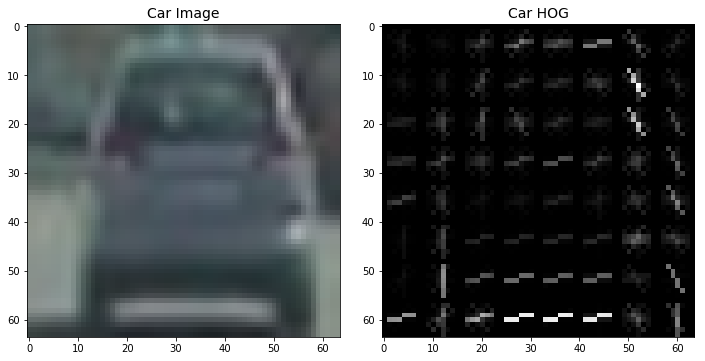

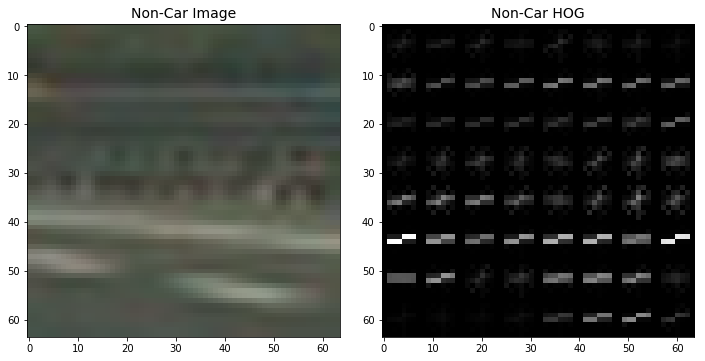

In [5]:


def test_car():
    img = mpimg.imread(car_images[1350])
    features, hog_image = get_hog_features(img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
    plot_images_side_by_side(img, 'Car Image', hog_image, 'Car HOG')

def test_non_car():
    img = mpimg.imread(noncar_images[1350])
    features, hog_image = get_hog_features(img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
    plot_images_side_by_side(img, 'Non-Car Image', hog_image, 'Non-Car HOG')

test_car()
test_non_car()


### Define a function to compute binned color features

_The code for this method was copied from the Udacity lesson materials:_

In [6]:
import cv2

def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features

### Define a function to compute color histogram features

_The code for this method was mostly copied from the Udacity lesson materials:_

In [7]:
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel_1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel_2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel_3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel_1_hist[0], channel_2_hist[0], channel_3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

### Extract features from a single image

_The code for this method was mostly copied from the Udacity lesson materials:_

In [8]:
def extract_single_img_features(img, color_space='RGB', spatial_size=(32, 32), hist_bins=32,
                                orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0,
                                spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    
    # Apply color conversion if other than 'RGB'
    if color_space == 'RGB':
        feature_image = np.copy(img)
    elif color_space == 'HSV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    elif color_space == 'LUV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    elif color_space == 'HLS':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    elif color_space == 'YUV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    elif color_space == 'YCrCb':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    
    # Compute spatial features if flag is set
    if spatial_feat == True:
        # Apply bin_spatial()
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Append features to list
        features.append(spatial_features)
    
    # Compute histogram features if flag is set
    if hist_feat == True:
        # Apply color_hist()
        hist_features = color_hist(feature_image, nbins=hist_bins)
        # Append features to list
        features.append(hist_features)
    
    if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel],
                                                     orient, pix_per_cell, cell_per_block,
                                                     vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel],
                                            orient, pix_per_cell, cell_per_block,
                                            vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    
    # Return concatenated array of feature vectors
    return np.concatenate(features)

### Extract features from a list of images

_The code for this method was mostly copied from the Udacity lesson materials:_

In [9]:
def extract_multiple_img_features(imgs, color_space='RGB', spatial_size=(32, 32), hist_bins=32,
                                  orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0,
                                  spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        img = mpimg.imread(file)
        # Extract features from a single image
        img_features = extract_single_img_features(img,
                                                   color_space=color_space,
                                                   spatial_size=spatial_size,
                                                   hist_bins=hist_bins,
                                                   orient=orient,
                                                   pix_per_cell=pix_per_cell,
                                                   cell_per_block=cell_per_block,
                                                   hog_channel=hog_channel,
                                                   spatial_feat=spatial_feat,
                                                   hist_feat=hist_feat,
                                                   hog_feat=hog_feat)
        # Append the features from the single image to the features list
        features.append(img_features)
    # Return list of feature vectors
    return features

In [10]:
# Parameters
color_space    = 'YCrCb'    # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient         = 9          # HOG orientations
pix_per_cell   = 8          # HOG pixels per cell
cell_per_block = 2          # HOG cells per block
hog_channel    = 'ALL'      # Can be 0, 1, 2, or "ALL"
spatial_size   = (16, 16)   # Spatial binning dimensions
hist_bins      = 16         # Number of histogram bins
spatial_feat   = True       # Spatial features on or off
hist_feat      = True       # Histogram features on or off
hog_feat       = True       # HOG features on or off
y_start_stop   = [420, 720] # Min and max in y to search in slide_window()

car_features = extract_multiple_img_features(car_images, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
noncar_features = extract_multiple_img_features(noncar_images, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)


In [11]:
np_car_features = np.array(car_features)
np_noncar_features = np.array(noncar_features)

print(np_car_features.shape)
print(np_noncar_features.shape)

(8792, 6108)
(8968, 6108)


### Train classifier

In [ ]:
from sklearn.svm import LinearSVC

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

### Sliding window technique

### Heatmap

### Heatmap threshold

This method was copied from lesson materials:

In [ ]:
def apply_threshold(heatmap, threshold=2):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

Once we have a thresholded heat-map, there are many ways we could go about trying to figure out how many cars we have in each frame and which pixels belong to which cars, but one of the most straightforward solutions is to use the `label()` function from `scipy.ndimage.measurements`.

In [ ]:
from scipy.ndimage.measurements import label

labels = label(heatmap)

In [ ]:
heatmap = apply_threshold(heatmap, 2)
labels = label(heatmap)
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')

The next method puts bounding boxes around the labeled regions on the image. This method was copied from lesson materials:

In [ ]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img